# Chapter Building Visual Question-Answering System

## 4.1 Download and preprocess dataset

### 4.1.2 Load and preprocess VQA dataset

In [1]:
%pip install pandas
%pip install utils
%pip install tensorboardX


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
import pandas as pd
from IPython.display import display

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [4]:
data_dir = '/Users/rajatgoel/Documents/Manning Book Multimodal AI/Personal Git Repo/data/Ch04'
# data_dir = os.path.join(os.getcwd(), 'data/Ch04')

#### Create Answer to Answer ID Mapping File

In [5]:
def create_answer_mapping(data_dir):
    annotation_file = os.path.join(data_dir, f'v2_mscoco_train2014_annotations.json')
    
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)['annotations']

    answer_to_id = {}
    id_to_answer = []
    id = 0
    for annotation in annotations:
        for answer in annotation['answers']:
            if answer['answer'] not in answer_to_id:
                answer_to_id[answer['answer']] = id
                id_to_answer.append(
                    {
                    'answer': answer['answer'], 
                    'frequency': 1
                    }
                )
                id += 1
            else:
               id_to_answer[answer_to_id[answer['answer']]]['frequency'] += 1

    sorted_mapping = sorted(id_to_answer, key=lambda x: x['frequency'], reverse=True)
    sorted_mapping = [{'answer_id': i, **d} for i, d in enumerate(sorted_mapping)]
    return pd.DataFrame(sorted_mapping)

In [6]:
answer_mapping_df = create_answer_mapping(data_dir)

In [7]:
display(answer_mapping_df)

,answer_id,answer,frequency
0,0,no,834552
1,1,yes,825565
2,2,2,122798
3,3,1,121020
4,4,white,80726
...,...,...,...
162491,162491,improved functionality,1
162492,162492,two computers,1
162493,162493,to talk to each other,1
162494,162494,different uses,1


In [8]:
answer_mapping_file = os.path.join(os.getcwd(), 'answer_mapping.json')
answer_mapping_df.to_json(answer_mapping_file, orient='records')

#### Create Word to Index mapping from Questions

In [9]:
from collections import Counter

In [10]:
def get_word2index_mapping_df(data_dir):
    question_file = os.path.join(data_dir, f'v2_OpenEnded_mscoco_train2014_questions.json')
    with open(question_file, 'r') as f:
        questions_df = pd.DataFrame(json.load(f)['questions'])
    questions = questions_df['question']

    all_words = []
    for text in questions:
        if isinstance(text, str):
            words = text.lower().split()  # Simple split by whitespace
            all_words.extend(words)
    word_frequencies = Counter(all_words)
    sorted_word_frequencies = sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)

    word_mapping = []
    idx = 0
    for word, freq in sorted_word_frequencies:
        word_mapping.append(
            {'index': idx, 'word': word, 'frequency': freq}
        )
        idx += 1
    
    word_mapping_df = pd.DataFrame(word_mapping)
    return word_mapping_df

In [11]:
word_mapping_df = get_word2index_mapping_df(data_dir)

In [12]:
display(word_mapping_df)

,index,word,frequency
0,0,the,322819
1,1,is,277120
2,2,what,184186
3,3,are,103976
4,4,this,75324
...,...,...,...
21137,21137,quacks?,1
21138,21138,fisher,1
21139,21139,gingerbread,1
21140,21140,merry,1


In [13]:
question_words_mapping_file = os.path.join(os.getcwd(), 'word_mapping.json')
word_mapping_df.to_json(question_words_mapping_file, orient='records')

#### Create Records from Question and Annotations

In [14]:
max_ans_index = 1500 # max number of answers to be predicted (top frequency answers selected)
max_ques_words = 1000 # max number of words in question vocabulary (top frequency words selected)

In [15]:
def merge_question_answers(data_dir, mode='train'):
    # Set file dirs
    annotation_file = os.path.join(data_dir, f'v2_mscoco_{mode}2014_annotations.json')
    question_file = os.path.join(data_dir, f'v2_OpenEnded_mscoco_{mode}2014_questions.json')
    
    with open(annotation_file, 'r') as f:
        annotation_df = pd.DataFrame(json.load(f)['annotations'])
    
    with open(question_file, 'r') as f:
        questions_df = pd.DataFrame(json.load(f)['questions'])

    merged_df = pd.merge(annotation_df, questions_df, on=('question_id', 'image_id'), how='inner')

    with open(answer_mapping_file, 'r') as f:
        answer_mapping_df = pd.DataFrame(json.load(f))
    truncated_answer_map_df = answer_mapping_df[:max_ans_index]

    joined_df = pd.merge(merged_df, truncated_answer_map_df, left_on='multiple_choice_answer', right_on='answer', how='left')
    joined_df = joined_df.drop('answer', axis=1) # drop duplicated column
    joined_df['frequency'] = joined_df['frequency'].fillna(1).astype(int)
    joined_df['answer_id'] = joined_df['answer_id'].fillna(max_ans_index).astype(int)

    columns_to_save = ['question_id', 'question', 'image_id', 'answer_id']
    joined_df = joined_df[columns_to_save]

    return joined_df

In [16]:
def encode_questions(joined_df, word_mapping_df, max_question_length=25, pad_token: str = '<pad>', unk_token: str = '<unk>'):
    word_to_index = pd.Series(word_mapping_df['index'].values, index=word_mapping_df['word']).to_dict()

    # Add padding and unknown tokens to the vocabulary if they are not already present
    if pad_token not in word_to_index:
        max_index = max(word_to_index.values()) if word_to_index else -1
        word_to_index[pad_token] = max_index + 1
    if unk_token not in word_to_index:
        max_index = max(word_to_index.values()) if word_to_index else -1
        word_to_index[unk_token] = max_index + 1

    encoded_questions_list = []
    for question_str in joined_df['question']:
        tokens = question_str.lower().split()  # Simple whitespace tokenization
        indices = [word_to_index.get(token, word_to_index.get(unk_token)) for token in tokens]

        # Padding and Truncating
        if len(indices) < max_question_length:
            indices = indices + [word_to_index[pad_token]] * (max_question_length - len(indices))
        else:
            indices = indices[:max_question_length]

        encoded_questions_list.append(indices)

    joined_df['encoded_question'] = encoded_questions_list
    return joined_df

In [17]:
train_records_df = merge_question_answers(data_dir, mode='train')

In [18]:
question_words_mapping_file = os.path.join(os.getcwd(), 'word_mapping.json')
word_mapping_df = pd.read_json(question_words_mapping_file)
train_records_df = encode_questions(train_records_df, word_mapping_df[:max_ques_words])

In [19]:
display(train_records_df)

,question_id,question,image_id,answer_id,encoded_question
0,458752000,What is this photo taken looking through?,458752,903,"[2, 1, 4, 78, 102, 98, 1001, 1000, 1000, 1000,..."
1,458752001,What position is this man playing?,458752,394,"[2, 708, 1, 4, 14, 91, 1000, 1000, 1000, 1000,..."
2,458752002,What color is the players shirt?,458752,23,"[2, 11, 1, 0, 332, 62, 1000, 1000, 1000, 1000,..."
3,458752003,Is this man a professional baseball player?,458752,1,"[1, 4, 14, 6, 473, 447, 780, 1000, 1000, 1000,..."
4,262146000,What color is the snow?,262146,4,"[2, 11, 1, 0, 415, 1000, 1000, 1000, 1000, 100..."
...,...,...,...,...,...
443752,524286001,What color is the keyboard?,524286,7,"[2, 11, 1, 0, 624, 1000, 1000, 1000, 1000, 100..."
443753,524286002,Is there a computer mouse on the desk?,524286,0,"[1, 12, 6, 224, 723, 8, 0, 436, 1000, 1000, 10..."
443754,524286003,What color is the computer?,524286,7,"[2, 11, 1, 0, 472, 1000, 1000, 1000, 1000, 100..."
443755,524286004,Why are there two keyboards?,524286,1500,"[47, 3, 12, 123, 1001, 1000, 1000, 1000, 1000,..."


In [20]:
train_records_output_file = os.path.join(os.getcwd(), 'train_records_output.json')
val_records_output_file = os.path.join(os.getcwd(), 'val_records_output.json')

In [21]:
train_records_df.to_json(train_records_output_file, orient='records')

In [22]:
val_records_df = merge_question_answers(data_dir, mode='val')
val_records_df = encode_questions(val_records_df, word_mapping_df[:max_ques_words])

In [23]:
display(val_records_df)

,question_id,question,image_id,answer_id,encoded_question
0,262148000,Where is he looking?,262148,110,"[18, 1, 41, 677, 1000, 1000, 1000, 1000, 1000,..."
1,262148001,What are the people in the background doing?,262148,495,"[2, 3, 0, 15, 5, 0, 331, 33, 1000, 1000, 1000,..."
2,262148002,What is he on top of?,262148,1500,"[2, 1, 41, 8, 97, 57, 1000, 1000, 1000, 1000, ..."
3,393225000,What website copyrighted the picture?,393225,1500,"[2, 1001, 1001, 0, 17, 1000, 1000, 1000, 1000,..."
4,393225001,Is this a creamy soup?,393225,0,"[1, 4, 6, 1001, 1001, 1000, 1000, 1000, 1000, ..."
...,...,...,...,...,...
214349,393212000,What is the main color in the photo?,393212,11,"[2, 1, 0, 440, 11, 5, 0, 32, 1000, 1000, 1000,..."
214350,393212001,What is the meaning of this sign?,393212,1500,"[2, 1, 0, 1001, 7, 4, 107, 1000, 1000, 1000, 1..."
214351,393212002,What is on the sign?,393212,1473,"[2, 1, 8, 0, 107, 1000, 1000, 1000, 1000, 1000..."
214352,393212003,Does the arrow point left or right?,393212,22,"[13, 0, 823, 1001, 94, 22, 211, 1000, 1000, 10..."


In [24]:
val_records_df.to_json(val_records_output_file, orient='records')

### 4.1.3 Save data loaders

In [25]:
class VQADataset(Dataset):
    def __init__(self, image_dir, records_file, transform, mode='train'):
        self.image_dir = image_dir
        self.transform = transform
        self.mode = mode
        with open(records_file, 'r') as f:
            self.records = json.load(f)

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        record = self.records[idx]
        image_id = record['image_id']
        image_path = os.path.join(self.image_dir, f"COCO_{self.mode}2014_{image_id:012d}.jpg")
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        return {
            'question_id': record['question_id'],
            'question': torch.tensor(record['encoded_question'], dtype=torch.long),
            'image_id': image_id,
            'image': image,
            'answer_id': record['answer_id']
        }

In [26]:
# Create data loader
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
train_image_dir = os.path.join(data_dir, 'train2014')
val_image_dir = os.path.join(data_dir, 'val2014')
train_records_output_file = os.path.join(os.getcwd(), 'train_records_output.json')
batch_size = 32

In [28]:
train_dataset = VQADataset(train_image_dir, train_records_output_file, transform, mode='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [29]:
val_dataset = VQADataset(val_image_dir, val_records_output_file, transform, mode='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [30]:
for batch in train_loader:
    print(len(batch))
    print(batch['question_id'][0])
    print(batch['question'][0])
    print(batch['image_id'][0])
    print(batch['image'][0].shape)
    print(batch['answer_id'][0])
    break # To get only one sample

5
tensor(127712007)
tensor([   2,  636,    3,    0,  439,   58,   30, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000])
tensor(127712)
torch.Size([3, 448, 448])
tensor(61)


In [31]:
torch.save(train_loader, os.path.join(os.getcwd(), 'train_loader.pth'))

In [32]:
torch.save(val_loader, os.path.join(os.getcwd(), 'val_loader.pth'))

## 4.2 Stacked Attention Network (SAN) Model

In [33]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import utils

### 4.2.3 The image model

In [34]:
class ImageEmbedding(nn.Module):
    def __init__(self, output_size=1024, extract_features=True, features_dir=None):
        super(ImageEmbedding, self).__init__()
        self.cnn = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features

        for param in self.cnn.parameters():
            param.requires_grad = False
        self.fc = nn.Sequential(
            nn.Linear(512, output_size),
            nn.Tanh())
        
        self.extract_features = extract_features
        self.features_dir = features_dir

    def forward(self, image, image_ids):
        # Image shape: torch.Size([32, 3, 448, 448])
        if self.extract_features:
            # N * 3 * 448 * 448 -> N * 512 * 14 * 14
            image_features = self.cnn(image)
            # Image shape after CNN:  torch.Size([32, 512, 14, 14])
            # N * 512 * 14 * 14 -> N * 512 * 196 -> N * 196 * 512
            image_features = image_features.flatten(start_dim=2).transpose(1, 2)
            # Image shape after transpose:  torch.Size([32, 196, 512])
            if self.features_dir is not None:
                utils.save_image_features(image_features, image_ids, self.features_dir)
            # N * 196 * 512 -> N * 196 * 1024 to make it same dim as ques embedding
            image_embedding = self.fc(image_features)
            return image_embedding
        else:
            return self.fc(image)

### 4.2.4 The question model

In [35]:
class QuesEmbedding(nn.Module):
    def __init__(self, input_size=500, output_size=1024, batch_first=True):
        super(QuesEmbedding, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=output_size, batch_first=batch_first)

    def forward(self, ques):
        # seq_len * N * 500 -> (1 * N * 1024, 1 * N * 1024) -> 1 * N * 1024
        _, (h, _) = self.lstm(ques) # get final hidden state and discard final cell state
        ques_embedding = h.squeeze(0) # get final hidden state 1 * N * 1024 -> N * 1024
        return ques_embedding

### 4.2.5 The attention model

In [36]:
class Attention(nn.Module):
    def __init__(self, d=1024, k=512, dropout=True):
        super(Attention, self).__init__()
        self.ff_image = nn.Linear(d, k)
        self.ff_ques = nn.Linear(d, k)
        if dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.ff_attention = nn.Linear(k, 1)
        self._attention_weights = None # To store attention weights

    def forward(self, vi, vq):
        # N * 196 * 1024 -> N * 196 * 512
        hi = self.ff_image(vi)
        # N * 1024 -> N * 512 -> N * 1 * 512
        hq = self.ff_ques(vq).unsqueeze(dim=1)
        # N * 196 * 512
        ha = F.tanh(hi + hq)
        if getattr(self, 'dropout'):
            ha = self.dropout(ha)
        # N * 196 * 512 -> N * 196 * 1 -> N * 196
        ha = self.ff_attention(ha).squeeze(dim=2)
        pi = F.softmax(ha, dim=1)
        self._attention_weights = pi # Store attention weights
        # (N * 196 * 1, N * 196 * 1024) -> N * 1024
        vi_attended = (pi.unsqueeze(dim=2) * vi).sum(dim=1)
        u = vi_attended + vq
        return u

    @property
    def attention_weights(self):
        return self._attention_weights

### 4.2.6 Define SAN model

In [37]:
class SANModel(nn.Module):
    def __init__(self, vocab_size, word_emb_size=500, emb_size=1024, att_ff_size=512, output_size=1000,
                 num_att_layers=2, extract_img_features=True, features_dir=None):
        super(SANModel, self).__init__()
        self.features_dir = features_dir
        self.image_channel = ImageEmbedding(output_size=emb_size, extract_features=extract_img_features,
                                            features_dir=features_dir)

        self.word_emb_size = word_emb_size
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_size)
        self.ques_channel = QuesEmbedding(
            word_emb_size, output_size=emb_size, batch_first=False)

        self.san = nn.ModuleList(
            [Attention(d=emb_size, k=att_ff_size)] * num_att_layers)

        self.mlp = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(emb_size, output_size))

        self._attention_weights = [] # To store attention weights from all layers

    def forward(self, images, questions, image_ids):
        image_embeddings = self.image_channel(images, image_ids)
        embeds = self.word_embeddings(questions)
        ques_embeddings = self.ques_channel(embeds)
        vi = image_embeddings
        u = ques_embeddings
        self._attention_weights = [] # ensure we're collecting weights for the current input
        for att_layer in self.san:
            u = att_layer(vi, u)
            self._attention_weights.append(att_layer.attention_weights) # Collect attention weights
        output = self.mlp(u)
        return output

    @property
    def attention_weights(self):
        return self._attention_weights

In [38]:
model = SANModel(
    vocab_size=max_ques_words+2, # +2 for padding and unknown token
    word_emb_size=500, 
    emb_size=1024, 
    att_ff_size=512, 
    output_size=max_ans_index,
    num_att_layers=2,
    extract_img_features=True, 
    features_dir=None
)

## 4.3 Train SAN Model

In [39]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")

In [40]:
train_loader = torch.load(os.path.join(os.getcwd(), 'train_loader.pth'), weights_only=False)

In [41]:
val_loader = torch.load(os.path.join(os.getcwd(), 'val_loader.pth'), weights_only=False)

In [42]:
criterion = nn.CrossEntropyLoss()

In [43]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), momentum=0.9, lr=0.01, weight_decay=0.0005)

In [44]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [45]:
from tqdm import tqdm

In [46]:
def train(model, dataloader, criterion, optimizer, max_batches=None):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0
    example_count = 0
    model.to(device)

    # Initialize tqdm progress bar
    progress_bar = tqdm(dataloader, desc="Training", total= max_batches if max_batches else len(dataloader))

    curr_batch = 0
    for batch in progress_bar:
        question_ids = batch['question_id']
        questions = batch['question']
        image_ids = batch['image_id']
        images = batch['image']
        answer_ids = batch['answer_id']
        
        questions = questions.transpose(0, 1).to(device)
        images = images.to(device)
        answer_ids = answer_ids.to(device)
        image_ids = image_ids.to(device)
        
        # zero grad
        optimizer.zero_grad()

        # forward
        ans_scores = model(images, questions, image_ids)
        _, preds = torch.max(ans_scores, 1)
        loss = criterion(ans_scores, answer_ids)

        # backward + optimize
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == answer_ids).item()
        example_count += answer_ids.size(0)
        
        # Update tqdm progress bar description
        progress_bar.set_postfix(loss=f"{running_loss / example_count:.4f}",
                               accuracy=f"{(running_corrects / example_count) * 100:.2f}%")

        curr_batch += 1
        if max_batches and curr_batch > max_batches:
            break

    # Final statistics
    loss = running_loss / example_count
    acc = (running_corrects / len(dataloader.dataset)) * 100
    print('Train Loss: {:.4f} Acc: {:2.3f} ({}/{})'.format(loss,
                                                           acc, running_corrects, example_count))
    return loss, acc

In [47]:
def validate(model, dataloader, criterion, max_batches=None):
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    example_count = 0
    model.to(device)

    # Initialize tqdm progress bar
    progress_bar = tqdm(dataloader, desc="Training", total= max_batches if max_batches else len(dataloader))

    curr_batch = 0
    for batch in progress_bar:
        question_ids = batch['question_id']
        questions = batch['question']
        image_ids = batch['image_id']
        images = batch['image']
        answer_ids = batch['answer_id']
        
        questions = questions.transpose(0, 1).to(device)
        images = images.to(device)
        answer_ids = answer_ids.to(device)
        image_ids = image_ids.to(device)

        # forward
        ans_scores = model(images, questions, image_ids)
        _, preds = torch.max(ans_scores, 1)
        loss = criterion(ans_scores, answer_ids)

        # statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == answer_ids).item()
        example_count += answer_ids.size(0)
        
        # Update tqdm progress bar description
        progress_bar.set_postfix(loss=f"{running_loss / example_count:.4f}",
                               accuracy=f"{(running_corrects / example_count) * 100:.2f}%")

        curr_batch += 1
        if max_batches and curr_batch > max_batches:
            break

    # Final statistics
    loss = running_loss / example_count
    acc = (running_corrects / len(dataloader.dataset)) * 100
    print('Validation Loss: {:.4f} Acc: {:2.3f} ({}/{})'.format(loss,
                                                           acc, running_corrects, example_count))
    return loss, acc

In [48]:
import shutil
import time

In [49]:
def save_checkpoint(save_dir, state, is_best):
    savepath = save_dir + '/' + 'checkpoint.pth.tar'
    torch.save(state, savepath)
    if is_best:
        shutil.copyfile(savepath, save_dir + '/' + 'model_best.pth.tar')

In [50]:
best_acc = 0
start_epoch = 0
num_epochs = 1
scheduler = exp_lr_scheduler

In [51]:
save_dir = os.path.join(os.getcwd(), 'san_lstm')
os.makedirs(save_dir, exist_ok=True)

In [52]:
for epoch in range(start_epoch, num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    train_begin = time.time()
    train_loss, train_acc = train(
        model, train_loader, criterion, optimizer
    )
    train_time = time.time() - train_begin
    print('Epoch Train Time: {:.0f}m {:.0f}s'.format(
        train_time // 60, train_time % 60))

    validation_begin = time.time()
    val_loss, val_acc = validate(
        model, val_loader, criterion
    )
    validation_time = time.time() - validation_begin
    print('Epoch Validation Time: {:.0f}m {:.0f}s'.format(
        validation_time // 60, validation_time % 60))

    # deep copy the model
    is_best = val_acc > best_acc
    if is_best:
        best_acc = val_acc
        best_model_wts = model.state_dict()

    save_checkpoint(save_dir, {
        'epoch': epoch,
        'best_acc': best_acc,
        'state_dict': model.state_dict(),
    }, is_best)

    valid_error = 1.0 - val_acc / 100.0
    scheduler.step()

Epoch 0/0
----------


Training: 100%|███████████████████████████████████████████████| 13868/13868 [4:48:29<00:00,  1.25s/it, accuracy=18.42%, loss=0.1146]


Train Loss: 0.1146 Acc: 18.420 (81741/443757)
Epoch Train Time: 288m 30s


Training: 100%|█████████████████████████████████████████████████| 6699/6699 [2:15:19<00:00,  1.21s/it, accuracy=18.74%, loss=0.1080]


Validation Loss: 0.1080 Acc: 18.743 (40176/214354)
Epoch Validation Time: 135m 19s


After the end of this training, we should have the best model saved in a file `model_best.pth.tar` which we will use in later sections of this chapter.

## 4.4 Visualize Attended Images

In [53]:
model_path = save_dir + '/' + 'model_best.pth.tar'

In [54]:
model.load_state_dict(torch.load(model_path, weights_only=False)["state_dict"])

<All keys matched successfully>

In [55]:
model.eval()

SANModel(
  (image_channel): ImageEmbedding(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tru

In [56]:
# Define image transformation
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [57]:
import matplotlib.pyplot as plt

In [58]:
def visualize_attention(image, attention_map, ax, title="Attention Map"):
    """Visualizes the attention map on the original image."""
    h, w = image.shape[1], image.shape[2] # Get original image dimensions for resizing the attention map
    resized_attention_map = attention_map.view(1, 1, 14, 14) # Reshape the attention map to 2D spatial map of 14 x 14 regions
    # upsample the smaller attention map (14x14) to the original image's height (h) and width (w)
    resized_attention_map = F.interpolate(resized_attention_map, size=(h, w), mode='bilinear', align_corners=False).squeeze()
    resized_attention_map = resized_attention_map.cpu().numpy()

    ax.imshow(image.permute(1, 2, 0).cpu().numpy()) # Show the original image by moving the tensor from GPU (if it's there) to CPU and then converts
    # it to a NumPy array, which is required by Matplotlib's imshow.
    ax.imshow(resized_attention_map, cmap='gray', alpha=0.9) # Overlay the attention map with grayscale colormap. The attended regions will be brighter than the non-attended ones.
    ax.set_title(title)
    ax.axis('off')

In [59]:
def generate_attention_images(model, image_path, question_tokens, word_to_index, device='cpu', unk_token: str = '<unk>'):
    """
    Generates images with attention filters from the first and second attention layers.

    Args:
        model (SANModel): Trained SAN model.
        image_path (str): Path to the input image.
        question_tokens (list): List of question tokens (strings).
        word_to_index (dict): Mapping from word to index.
        device (str): 'cpu' or 'cuda'.

    Returns:
        matplotlib.figure.Figure: Figure containing the original image and attention maps.
    """
    model.to(device)
    model.eval()

    # 1. Load and preprocess the image
    try:
        img = Image.open(image_path).convert('RGB')
        image_tensor = transform(img).unsqueeze(0).to(device)
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None

    # 2. Convert question tokens to indices
    question_indices = [word_to_index.get(token, word_to_index.get(unk_token, 0)) for token in question_tokens]
    question_tensor = torch.tensor(question_indices).unsqueeze(1).to(device) # (seq_len, batch_size=1)
    image_id_tensor = torch.tensor([0]).to(device) # Dummy image_id

    # 3. Forward pass through the model
    with torch.no_grad():
        _ = model(image_tensor, question_tensor, image_id_tensor)

    # 4. Extract attention maps
    attention_maps = model.attention_weights
    num_attention_layers = len(attention_maps)

    if num_attention_layers > 0:
        fig, axes = plt.subplots(1, num_attention_layers + 1, figsize=(5 * (num_attention_layers + 1), 5))
        axes[0].imshow(img.resize((448, 448)))
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        for i in range(num_attention_layers):
            attention_map = attention_maps[i].squeeze(0).cpu() # (num_regions)
            # Reshape attention map to match the spatial feature map size (assuming 14x14)
            attention_map_resized = attention_map.view(14, 14)
            visualize_attention(image_tensor.squeeze(0), attention_map_resized.unsqueeze(0), axes[i + 1], title=f"Attention Layer {i+1}")

        return fig
    else:
        print("Error: No attention weights found in the model.")
        return None

In [60]:
# Example usage:
# 1. Load your trained model and word-to-index mapping
# Assuming you have a dictionary 'word_to_index'

pad_token: str = '<pad>'
unk_token: str = '<unk>'
word_mapping_df = pd.read_json(question_words_mapping_file)
word_mapping_df = word_mapping_df[:max_ques_words]

word_to_index = pd.Series(word_mapping_df['index'].values, index=word_mapping_df['word']).to_dict() # Create word to index mapping
word_to_index[pad_token] = max_ques_words
word_to_index[unk_token] = max_ques_words + 1

# 2. Specify the image path and question
image_id = 5673
image_path = os.path.join(data_dir, f"val2014/COCO_val2014_{image_id:012d}.jpg")
question = "Is the man wearing glasses?"
question_tokens = question.lower().split()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


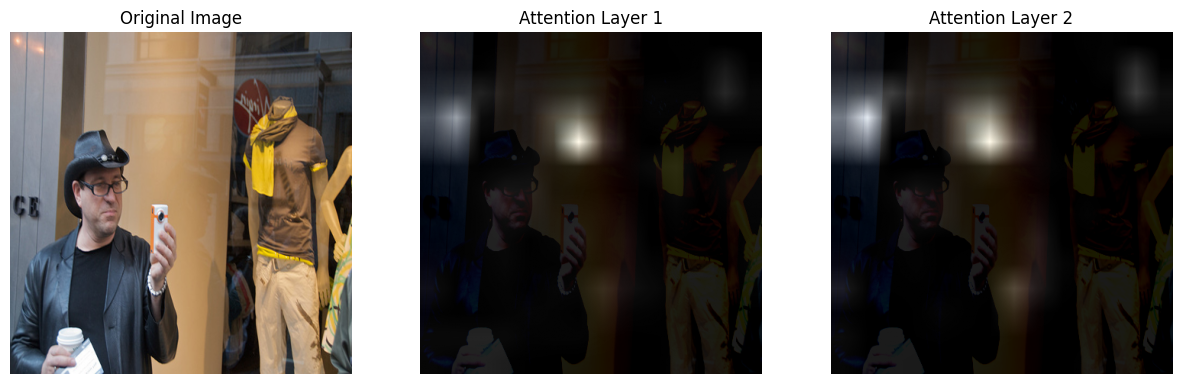

In [61]:
# 3. Generate and display the attention images
attention_figure = generate_attention_images(model, image_path, question_tokens, word_to_index)

if attention_figure:
    plt.show()

## 4.5 Make Model Inference

In [62]:
def perform_inference(trained_model, image_path, question_text, word_to_index, device='cpu', max_question_length=20):
    trained_model.eval()
    trained_model.to(device)

    # 1. Load and preprocess the image
    try:
        img = Image.open(image_path).convert('RGB')
        image_tensor = transform(img).unsqueeze(0).to(device) # Add batch dimension
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None

    # 2. Tokenize and encode the question
    question_tokens = question_text.lower().split()
    question_indices = [word_to_index.get(token, word_to_index.get('<unk>', 0)) for token in question_tokens]

    # Pad or truncate the question to a fixed length (if needed by your model)
    if len(question_indices) < max_question_length:
        question_indices += [word_to_index.get('<pad>', 0)] * (max_question_length - len(question_indices))
    elif len(question_indices) > max_question_length:
        question_indices = question_indices[:max_question_length]

    question_tensor = torch.tensor(question_indices).unsqueeze(1).to(device) # (seq_len, batch_size=1)

    # 3. Create dummy image IDs (if your model uses them)
    image_ids_tensor = torch.tensor([0]).to(device) # Shape (batch_size=1,)

    # 4. Perform the forward pass (no gradient calculation needed for inference)
    with torch.no_grad():
        output = trained_model(image_tensor, question_tensor, image_ids_tensor)

    # 5. Process the output
    # Assuming your output is logits over classes
    probabilities = torch.softmax(output, dim=1)
    predicted_class_index = torch.argmax(probabilities, dim=1).item()

    return predicted_class_index, probabilities.squeeze().cpu().numpy()


In [63]:
predicted_class_index, probs = perform_inference(trained_model=model, image_path=image_path, question_text=question, word_to_index=word_to_index, device=device, max_question_length=20)

In [64]:
print(predicted_class_index)
print(probs)

1
[1.5752830e-01 2.8834167e-01 2.1095987e-02 ... 1.0073166e-04 1.3672023e-04
 1.1689300e-04]


Now that we have the predicted answer ID, we just need to translate this ID to the answer string, which is done with the help of the answer to answer ID mapping, which we had already stored in a file in section 4.1.2. So we load that file to get the final answer as follows.

In [65]:
with open(answer_mapping_file, 'r') as f:
    answer_mapping_df = pd.DataFrame(json.load(f))
predicted_row = answer_mapping_df.loc[answer_mapping_df['answer_id'] == predicted_class_index]

In [66]:
display(predicted_row)

,answer_id,answer,frequency
1,1,yes,825565


In [67]:
print("Answer is: ", predicted_row.iloc[0]["answer"])

Answer is:  yes


### Read annotations

In [ ]:
with open(annotation_file, 'r') as f:
    annotation_df = pd.DataFrame(json.load(f)['annotations'])

In [ ]:
display(annotation_df)

In [ ]:
# check if there are any duplicates with question_id
print(any(annotation_df['question_id'].duplicated()))

### Read Questions

In [ ]:
with open(question_file, 'r') as f:
    questions_df = pd.DataFrame(json.load(f)['questions'])

In [ ]:
display(questions_df)

### Merge Annotation and Questions

In [ ]:
merged_df = pd.merge(annotation_df, questions_df, on=('question_id', 'image_id'), how='inner')

In [ ]:
display(merged_df)

In [ ]:
with open(answer_mapping_file, 'r') as f:
    answer_mapping_df = pd.DataFrame(json.load(f))

In [ ]:
display(answer_mapping_df)

In [ ]:
row = answer_mapping_df.iloc[max_ans_index]
print(row)

In [ ]:
truncated_answer_map_df = answer_mapping_df[:max_ans_index]
print(len(truncated_answer_map_df))
row = truncated_answer_map_df.iloc[-1]
print(row)

In [ ]:
joined_df = pd.merge(merged_df, truncated_answer_map_df, left_on='multiple_choice_answer', right_on='answer', how='left')
joined_df = joined_df.drop('answer', axis=1)
joined_df['frequency'] = joined_df['frequency'].fillna(1).astype(int)
joined_df['answer_id'] = joined_df['answer_id'].fillna(max_ans_index).astype(int)

In [ ]:
display(joined_df)

In [ ]:
# Add data to records file
columns_to_save = ['question_id', 'question', 'image_id', 'answer_id']
joined_df = joined_df[columns_to_save]

### Write file for Question word vocab

In [ ]:
from collections import Counter

In [ ]:
questions = pd.read_json(records_output_file)['question']

In [ ]:
all_words = []
for text in questions:
    if isinstance(text, str):
        words = text.lower().split()  # Simple split by whitespace
        all_words.extend(words)
word_frequencies = Counter(all_words)
sorted_word_frequencies = sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)

In [ ]:
word_mapping = []
idx = 0
for word, freq in sorted_word_frequencies:
    word_mapping.append(
        {
            'index': idx,
            'word': word,
            'frequency': freq
        }
    )
    idx += 1

word_mapping_df = pd.DataFrame(word_mapping)

In [ ]:
word_mapping_df.to_json(question_words_mapping_file, orient='records')

### Read question word mapping file

In [ ]:
word_mapping_df = pd.read_json(question_words_mapping_file)
display(word_mapping_df)

In [ ]:
word_mapping_df[:max_ques_words]

### Update records df to add question encoding

In [ ]:
joined_df = encode_questions(joined_df, word_mapping_df[:max_ques_words])

In [ ]:
display(joined_df)

In [ ]:
# Check length of question with max words
max_length = 0
for question_str in joined_df['question']:
    words = question_str.lower().split()  # Simple whitespace tokenization
    max_length = max(max_length, len(words))

print(max_length)

### Write to Records Output File

In [ ]:
joined_df.to_json(records_output_file, orient='records')